## **Similarity Search System:**
- Leveraged a ResNet pretrained model for efficient feature extraction.
- Applied PCA to reduce dimensionality from 2048 to 150 features, enhancing performance.
- Implemented KNN to quickly retrieve nearest neighbors, identifying similar images in the dataset.

# Downloading Data Set
#### Description:

- Caltech-101 consists of pictures of objects belonging to 101 classes, plus one background clutter class.
- Each image is labelled with a single object. Each class contains roughly 40 to 800 images, totalling around 9k images.
- Images are of variable sizes, with typical edge lengths of 200-300 pixels.
- This version contains image-level labels only. The original dataset also contains bounding boxes.


In [ ]:
# Download the dataset using gdown
!pip install gdown
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output caltech101.tar.gz

# Extract the tar.gz file
!tar -xvzf caltech101.tar.gz

# Move the extracted folder to a desired location
!mkdir -p datasets
!mv 101_ObjectCategories datasets/caltech101

# Remove the BACKGROUND_Google folder
!rm -rf datasets/caltech101/BACKGROUND_Google

# Optional: Clean up by removing the downloaded tar.gz file
!rm caltech101.tar.gz


# Connecting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [5]:
cd /content/gdrive/My Drive/Colab Notebooks/


[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/'
/content


In [ ]:
!mkdir -p data
!pip install gdown
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output data/caltech101.tar.gz
!tar -xvzf data/caltech101.tar.gz --directory data
!mv data/101_ObjectCategories data/caltech101
!rm -rf data/caltech101/BACKGROUND_Google

# Importing Required libraries:

In [35]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Loading Pre traned model

In [23]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet',
                          include_top=False,
                        input_shape=(224, 224, 3),
                        pooling='max')

94765736/94765736 [==============================] - 1s 0us/step


In [37]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       



# Feature Extraction :



In [48]:
from tensorflow.keras.preprocessing import image
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [51]:
IMG_PATH ='/content/datasets/caltech101/Faces/image_0001.jpg'
features = extract_features(IMG_PATH, model)
print("Total length of features for one image: ", len(features))

1/1 [==============================] - 0s 221ms/step
Total length of features for one image:  2048


In [52]:
%timeit features = extract_features(IMG_PATH, model)

1/1 [==============================] - 0s 193ms/step
357 ms ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Feature Extraction in Entrie Data set

In [44]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

In [45]:
# path to the your datasets
import os
root_dir = '/content/datasets/caltech101'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

8677


In [ ]:
filenames[8660:]

In [47]:
BATCH_SIZE = 128
generator = tf.keras.utils.image_dataset_from_directory(root_dir,
                                            shuffle=False,
                                           batch_size=BATCH_SIZE,
                                            image_size=(224,224))

num_images = len(generator.file_paths)
num_epochs = int(math.ceil(num_images / BATCH_SIZE))

start_time = time.time()
feature_list = []
feature_list = model.predict(generator, num_epochs)
end_time = time.time()

Found 8677 files belonging to 101 classes.
68/68 [==============================] - 2033s 30s/step


In [53]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(len(feature_list), -1)

print("Num images   = ", len(generator.file_paths))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in min = ", (end_time - start_time)/60)

Num images   =  8677
Shape of feature_list =  (8677, 2048)
Time taken in min =  33.88949220577876


In [69]:
feature_list[0].shape


(2048,)

# Saving those Feature map

In [64]:
pickle.dump(generator.class_names, open('/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/class_ids-caltech101.pickle',
                                    'wb'))
pickle.dump(generator.file_paths, open('/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/filenames-caltech101.pickle', 'wb'))
pickle.dump(
    feature_list,
    open('/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/features-caltech101-' + 'resnet50' + '.pickle', 'wb'))

# Loading THe Feature Map

In [65]:
filenames = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/features-caltech101-resnet50.pickle',
                                'rb'))
class_ids = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Git/Image Simillarity/class_ids-caltech101.pickle", 'rb'))

In [66]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [70]:
feature_list.shape #each image has 2048 datpoints as  featuremap

(8677, 2048)

In [73]:
len(class_ids)

101

In [ ]:
class_ids

In [80]:
len(filenames),len(feature_list)
# filenames is just like labels corresponding features list

(8677, 8677)

In [90]:
print(filenames[:3])

['/content/datasets/caltech101/Faces/image_0001.jpg', '/content/datasets/caltech101/Faces/image_0002.jpg', '/content/datasets/caltech101/Faces/image_0003.jpg']


In [91]:
print(feature_list[:3])

[[0.01249448 0.03039279 0.01010043 ... 0.01667376 0.0137787  0.02568888]
 [0.01016344 0.04531006 0.00324879 ... 0.00990618 0.00213944 0.00886555]
 [0.00930622 0.00731346 0.01065078 ... 0.00833448 0.00481808 0.00012371]]


#Visualizing Some images Ramdomly

In [ ]:
random_index = random.randint(0, num_images)
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[random_index]])


In [ ]:
%timeit distances, indices = neighbors.kneighbosr([feature_list[random_index]])

51.9 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


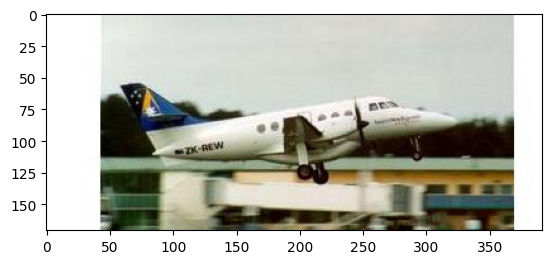

In [84]:
plt.imshow(mpimg.imread(filenames[random_index]))

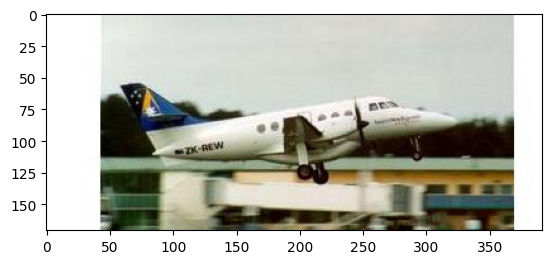

In [85]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

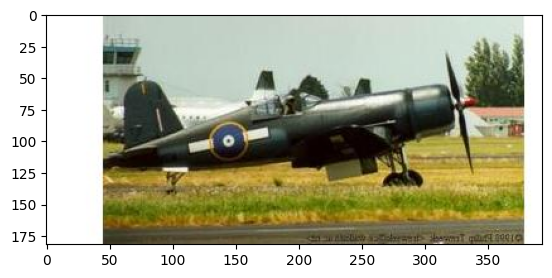

In [86]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

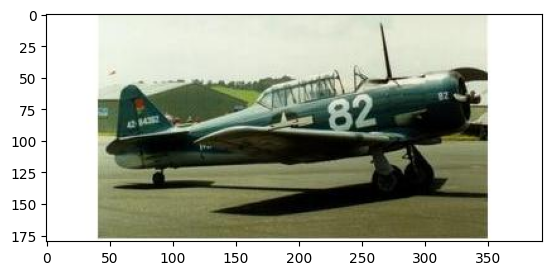

In [87]:
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

In [88]:
for i in range(5):
    print(distances[0][i])

0.0
0.6587586591249189
0.6856199698320167
0.6882659156987666
0.6950144825599636


# Similarity Search:

- Given a QUERY image, our aim is to find another photo in our dataset similar to the current one.

- We begin by loading the precomputed features:


In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]

# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]

# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    rows = math.ceil(len(images) / columns)  # Calculate number of rows
    for i, image in enumerate(images):
        ax = plt.subplot(rows, columns, i + 1)  # Use integer for rows
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        plt.axis('off')  # Hide axis
    plt.show()


In [95]:
for i in range(10):
    random_image_index = random.randint(0, 8000)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

Output hidden; open in https://colab.research.google.com to view.

In [96]:
# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  0.657551859235568
Max distance between all photos:  0.7148318680573087
Median distance among most similar photos:  0.657551859235568


# Calculating Accuracy of the Brute Force Model :

In [97]:
# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [ ]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

# Visualizing Image Clusters with t-SNE:

Let’s step up the game by visualizing the entire dataset!

- To do this, we need to reduce the dimensions of the feature vectors because it’s not possible to plot a 2,048-dimension vector (the feature-length) in two dimensions (the paper).
- The t-distributed stochastic neighbor embedding (t-SNE) algorithm reduces the high-dimensional feature vector to 2D, providing a bird’s-eye view of the dataset, which is helpful in recognizing clusters and nearby images.
- t-SNE is difficult to scale to large datasets, so it is a good idea to reduce the dimensionality using Principal Component Analysis (PCA) and then call t-SNE:

In [99]:
# Perform PCA over the features
num_feature_dimensions=150 # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

In [100]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list_compressed)
distances, indices = neighbors.kneighbors([feature_list_compressed[random_index]])
%timeit distances, indices = neighbors.kneighbors([feature_list_compressed[random_index]])

6.52 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
print(len(tsne_results))          # Should be 4000
print(len(class_ids_numeric))     # Should also be 4000


4000
101


In [108]:
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]


In [109]:
import numpy as np

# Convert class names to numeric labels
unique_classes, class_ids_numeric = np.unique(selected_class_ids, return_inverse=True)


In [110]:
# Ensure all selected data are of the same length
print(len(selected_features))   # Should be 4000
print(len(selected_class_ids))  # Should be 4000
print(len(filenames))           # Ensure filenames are also consistent, if needed


4000
101
8677


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming these are defined elsewhere in your code
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]

# Convert class names to numeric labels if necessary
unique_classes, class_ids_numeric = np.unique(selected_class_ids, return_inverse=True)

# Check lengths to ensure they match
print(len(tsne_results))          # Should be 4000
print(len(class_ids_numeric))     # Should also be 4000

# Perform t-SNE
tsne_results = TSNE(n_components=2, verbose=1, metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
#colormap = plt.colormaps.get_cmap('coolwarm')
#scatter_plot = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=class_ids_numeric, cmap=colormap)
#plt.colorbar(scatter_plot)
#plt.show()


4000
101
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.159004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.197327
[t-SNE] KL divergence after 1000 iterations: 1.125852


In [114]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data


def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [115]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

In [116]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

Output hidden; open in https://colab.research.google.com to view.

# Accuracy of Brute Force over the PCA compressed Caltech101 features


In [117]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  15.42 % ,	Time =  15.45298981666565
For PCA Dimensions =  2 ,	Accuracy =  26.15 % ,	Time =  10.54147219657898
For PCA Dimensions =  3 ,	Accuracy =  32.4 % ,	Time =  10.919215202331543
For PCA Dimensions =  4 ,	Accuracy =  40.07 % ,	Time =  11.08074140548706
For PCA Dimensions =  5 ,	Accuracy =  45.93 % ,	Time =  11.370014667510986
For PCA Dimensions =  10 ,	Accuracy =  63.88 % ,	Time =  12.562250852584839
For PCA Dimensions =  20 ,	Accuracy =  77.79 % ,	Time =  14.112013578414917
For PCA Dimensions =  50 ,	Accuracy =  85.24 % ,	Time =  20.40710759162903
For PCA Dimensions =  75 ,	Accuracy =  86.38 % ,	Time =  28.37800884246826
For PCA Dimensions =  100 ,	Accuracy =  86.82 % ,	Time =  33.40454697608948
For PCA Dimensions =  150 ,	Accuracy =  87.07 % ,	Time =  50.07637667655945
For PCA Dimensions =  200 ,	Accuracy =  87.05 % ,	Time =  70.64983296394348
